In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Items Shipped by Item by Month.csv')

In [125]:
df.head()

,Date,Item,Item Description,Product Group,Parent Product Group,Quantity,Amount
0,2024-Sep,2151,Original 36in Griddle W/Hood,Griddles,Cooking Unit,168.0,42504.00
1,2024-Sep,5482SA,"36"" Griddle with hood cover - Saudi Arabia",Covers/Bags - GRD,Accessory,297.0,6073.65
2,2024-Sep,5483SA,"28"" GRIDDLE COVER - Saudi Arabia",Covers/Bags - GRD,Accessory,297.0,5702.40
3,2024-Sep,1868DK,36 inch Griddle with Air Fryer (EU Low-Pressure),Griddles,Cooking Unit,51.0,21039.03
4,2024-Sep,1785DK,Griddle Plus 28in 2 Drawer Airfryer Griddle (E...,Griddles,Cooking Unit,78.0,24724.44


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385794 entries, 0 to 385793
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  385794 non-null  object 
 1   Item                  385794 non-null  object 
 2   Item Description      383866 non-null  object 
 3   Product Group         378120 non-null  object 
 4   Parent Product Group  385794 non-null  object 
 5   Quantity              384823 non-null  float64
 6   Amount                385794 non-null  float64
dtypes: float64(2), object(5)
memory usage: 20.6+ MB


In [127]:
df['Date'] = pd.to_datetime(df['Date'])

In [128]:
item = '4114'

df = df.groupby(['Date','Item'])['Quantity'].sum().reset_index().sort_values(by='Date', ascending=True)

df_item = df[df['Item'] == item]

df_item = df_item.resample('M', on='Date').sum().reset_index()

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56799 entries, 0 to 56798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      56799 non-null  datetime64[ns]
 1   Item      56799 non-null  object        
 2   Quantity  56799 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.7+ MB


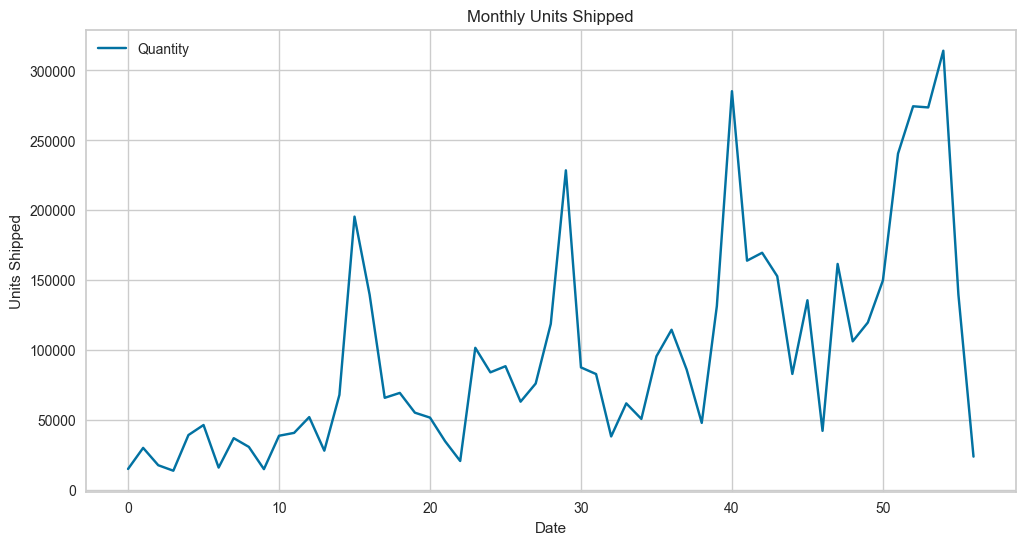

In [130]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df_item.index , df_item['Quantity'], label='Quantity')
plt.title('Monthly Units Shipped')
plt.xlabel('Date')
plt.ylabel('Units Shipped')
plt.legend()
plt.show()

## Data Transformation

### Box Cox Transformation

In [131]:
from scipy.stats import boxcox

        Date  Item  Quantity  boxcox_units
0 2020-01-31  4114   14981.0     16.530346
1 2020-02-29  4114   30057.0     18.495433
2 2020-03-31  4114   17657.0     16.981401
3 2020-04-30  4114   13723.0     16.292769
4 2020-05-31  4114   39238.0     19.286191


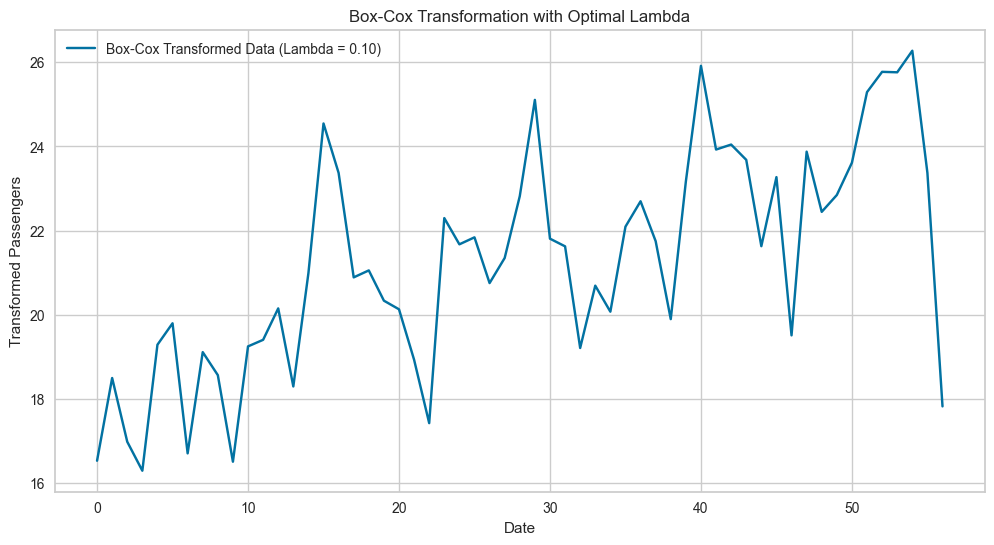

The optimal lambda for Box-Cox transformation is: 0.10411578236645244


In [132]:

# Apply Box-Cox transformation to find the optimal lambda
df_item['boxcox_units'] , optimal_lambda = boxcox(df_item.Quantity)
print(df_item.head())

# Plot the transformed data with optimal lambda
plt.figure(figsize=(12, 6))
plt.plot(df_item.index, df_item['boxcox_units'] , label=f'Box-Cox Transformed Data (Lambda = {optimal_lambda:.2f})')
plt.title('Box-Cox Transformation with Optimal Lambda')
plt.xlabel('Date')
plt.ylabel('Transformed Passengers')
plt.legend()
plt.show()

# Print the optimal lambda
print(f'The optimal lambda for Box-Cox transformation is: {optimal_lambda}')

## ACF and PACF

In [133]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

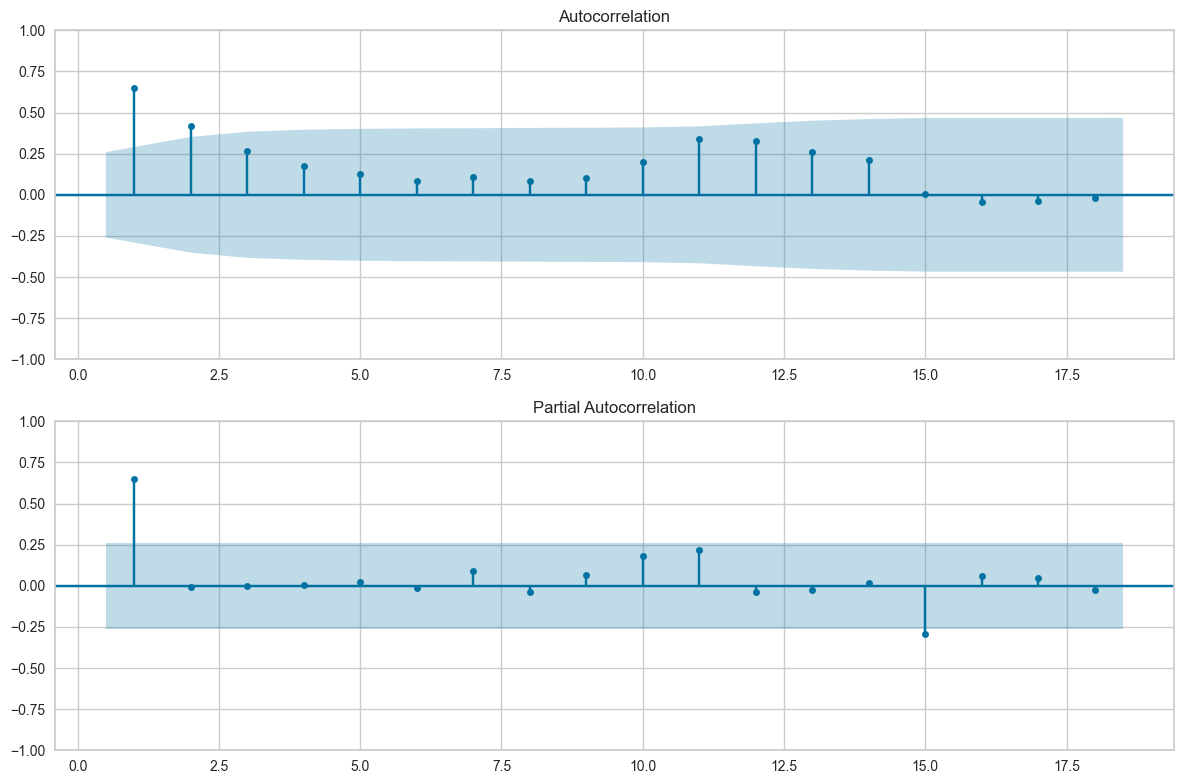

In [134]:
# Plot ACF and PACF for the original airline passenger data
plt.figure(figsize=(12, 8))
plt.subplot(211)
plot_acf(df_item['Quantity'], ax=plt.gca(), zero=False)
plt.subplot(212)
plot_pacf(df_item['Quantity'], ax=plt.gca(), zero=False)
plt.tight_layout()
plt.show()

## Stationarity

In [135]:
from statsmodels.tsa.stattools import adfuller

In [136]:
# Function to perform ADF test
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")

Augmented Dickey-Fuller Test: boxcox quantity- Differenced
ADF Test Statistic             -4.602961
p-value                         0.000128
# Lags Used                     9.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
=> The series is stationary.


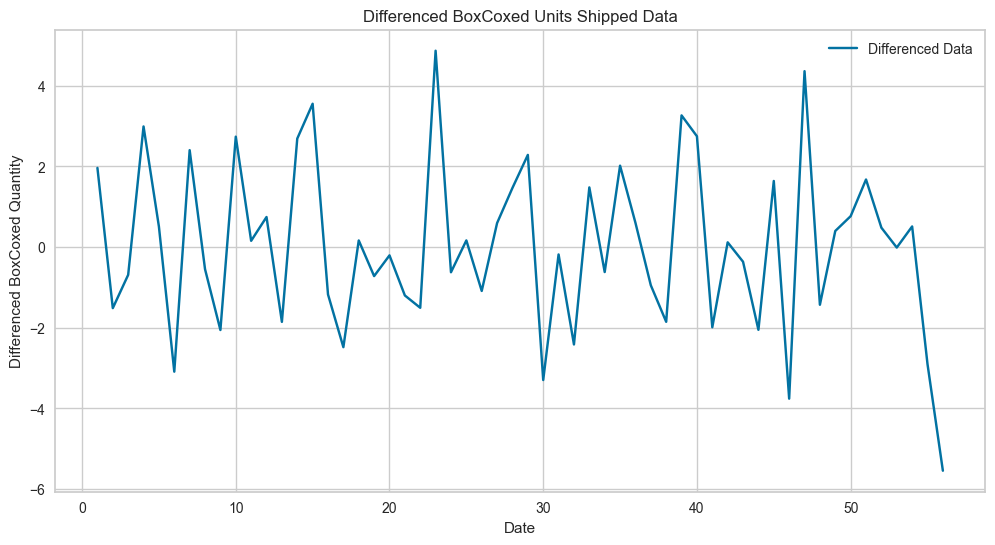

In [137]:
df_item['boxcox_quantity_diff'] = df_item['boxcox_units'].diff()

# Perform ADF test on differenced data
adf_test(df_item['boxcox_quantity_diff'].dropna(), title='boxcox quantity- Differenced')

# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(df_item.index , df_item['boxcox_quantity_diff'], label='Differenced Data')
plt.title('Differenced BoxCoxed Units Shipped Data')
plt.xlabel('Date')
plt.ylabel('Differenced BoxCoxed Quantity')
plt.legend()
plt.show()

## Benchmarking

#### Multi-Horizon Benchmark

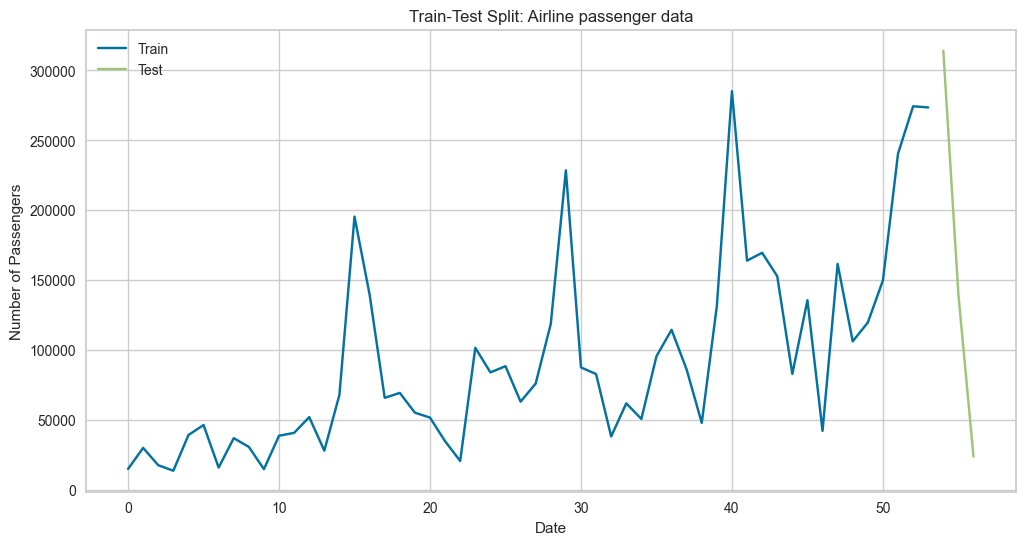

In [138]:
# Split the data
train = df_item[['Quantity']][:-3]
test = df_item[['Quantity']][-3:]

# Visualize the train and test data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.title('Train-Test Split: Airline passenger data')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

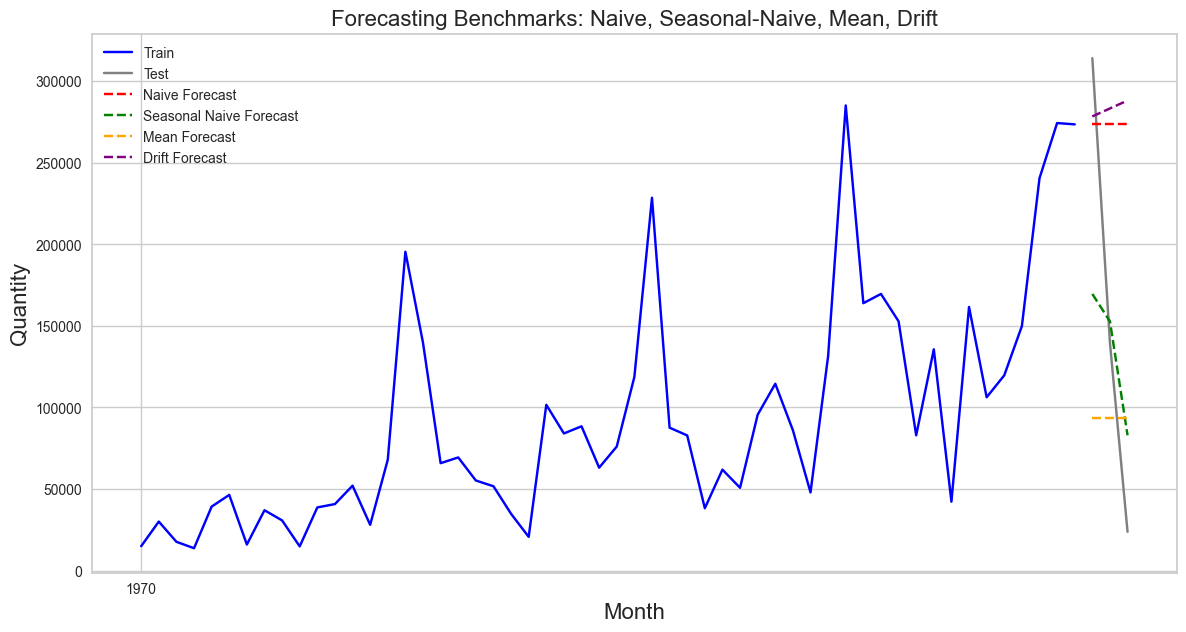

In [139]:
# Naive Forecast
# The naive forecaster simply uses the last observation from the training set
# as the forecast for all future observations.
y_hat_naive = test.copy()
y_hat_naive['naive'] = train.iloc[-1]['Quantity']

# Seasonal Naive Forecast:
# The seasonal naive forecaster uses the observation 
# from the same season of the previous cycle as the forecast.
season_length = 12
train_values_for_snaive = train['Quantity'].values[-season_length:]  # Last season's data
y_hat_snaive = test.copy()
y_hat_snaive['snaive'] = np.tile(train_values_for_snaive, len(test)//season_length+1)[:len(test)]

# Mean Forecast:
# The mean forecaster uses the mean of the training set as the forecast for all future observations.
y_hat_mean = test.copy()
y_hat_mean['mean'] = train['Quantity'].mean()

# Drift Forecast:
# The drift forecaster extrapolates a line between the first and last observations
# in the training set.
y_hat_drift = test.copy()
num_periods = len(train) - 1
drift = (train['Quantity'].iloc[-1] - train['Quantity'].iloc[0]) / num_periods
y_hat_drift['drift'] = [train['Quantity'].iloc[-1] + (i+1) * drift for i in range(len(test))]


# Ensure index types are correct
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
y_hat_naive.index = pd.to_datetime(y_hat_naive.index)
y_hat_snaive.index = pd.to_datetime(y_hat_snaive.index)
y_hat_mean.index = pd.to_datetime(y_hat_mean.index)
y_hat_drift.index = pd.to_datetime(y_hat_drift.index)

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Quantity'], label='Train', color='blue')
plt.plot(test.index, test['Quantity'], label='Test', color='grey')
plt.plot(y_hat_naive.index, y_hat_naive['naive'], label='Naive Forecast', color='red', linestyle='--')
plt.plot(y_hat_snaive.index, y_hat_snaive['snaive'], label='Seasonal Naive Forecast', color='green', linestyle='--')
plt.plot(y_hat_mean.index, y_hat_mean['mean'], label='Mean Forecast', color='orange', linestyle='--')
plt.plot(y_hat_drift.index, y_hat_drift['drift'], label='Drift Forecast', color='purple', linestyle='--')

plt.title('Forecasting Benchmarks: Naive, Seasonal-Naive, Mean, Drift', fontsize=16)
plt.xlabel('Month',fontsize=16)
plt.ylabel('Quantity',fontsize=16)
plt.legend(loc='upper left')
plt.show()

#### One Step ahead benchmark

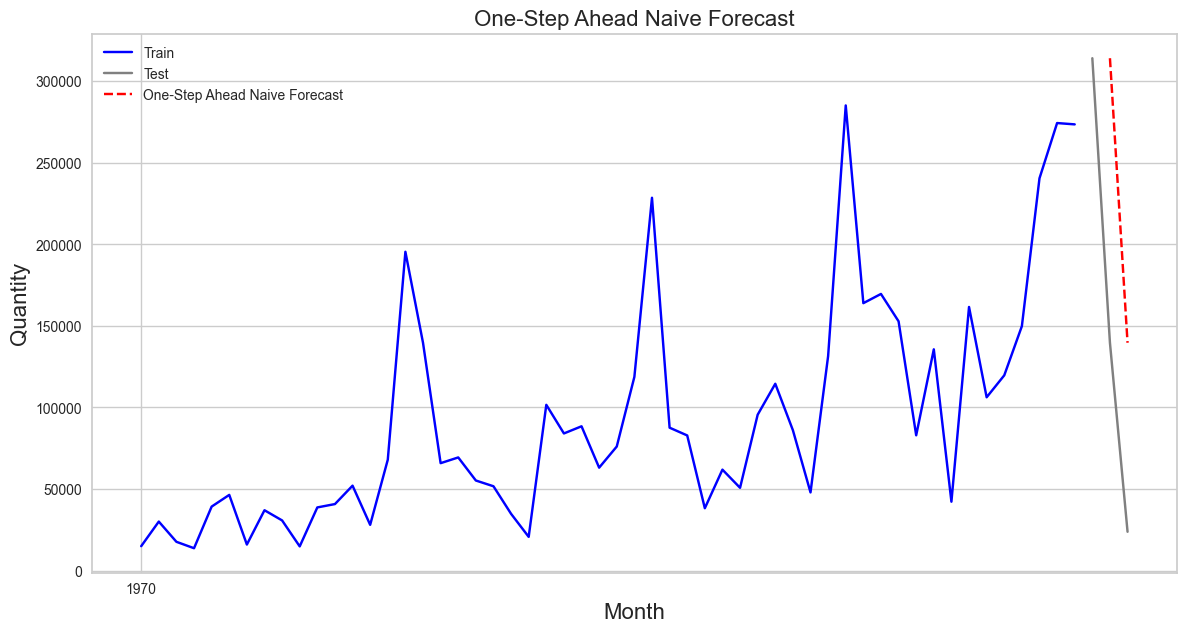

In [140]:
# Correcting the Naive Forecast for a true one-step ahead visualization
y_hat_naive_corrected = df_item.copy()
y_hat_naive_corrected['naive_one_step'] = df_item['Quantity'].shift(1)

# Adjusting visualization to focus on one-step ahead naive forecast in the test set
plt.figure(figsize=(14, 7))

# Original data (Train and Test)
plt.plot(train.index, train['Quantity'], label='Train', color='blue')
plt.plot(test.index, test['Quantity'], label='Test', color='grey')

# One-step ahead naive forecast (Test set only)
# Shifting the test data one step for the naive forecast
test_shifted_for_naive = test['Quantity'].shift(1)
plt.plot(test.index, test_shifted_for_naive, label='One-Step Ahead Naive Forecast', color='red', linestyle='--')

plt.title('One-Step Ahead Naive Forecast', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Quantity',fontsize=16)
plt.legend(loc='upper left')
plt.show()

## Pycaret Forecast

In [141]:
from pycaret.time_series import *

In [142]:
df_item.head()

,Date,Item,Quantity,boxcox_units,boxcox_quantity_diff
0,2020-01-31,4114,14981.0,16.530346,NaN
1,2020-02-29,4114,30057.0,18.495433,1.965087
2,2020-03-31,4114,17657.0,16.981401,-1.514032
3,2020-04-30,4114,13723.0,16.292769,-0.688632
4,2020-05-31,4114,39238.0,19.286191,2.993423


In [143]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  57 non-null     datetime64[ns]
 1   Item                  57 non-null     object        
 2   Quantity              57 non-null     float64       
 3   boxcox_units          57 non-null     float64       
 4   boxcox_quantity_diff  56 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 2.4+ KB


In [144]:
df_item = df_item.drop(columns = ['Item','Quantity','boxcox_units'])
df_item = df_item.set_index('Date')
df_item.tail()

,boxcox_quantity_diff
Date,
2024-05-31,0.481894
2024-06-30,-0.010942
2024-07-31,0.512672
2024-08-31,-2.902744
2024-09-30,-5.547581


In [145]:
exp = TSForecastingExperiment()
exp.setup(data = df_item, target='boxcox_quantity_diff', numeric_imputation_target='mean', fh=3)

,Description,Value
0,session_id,2777
1,Target,boxcox_quantity_diff
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(57, 1)"
5,Transformed data shape,"(57, 1)"
6,Transformed train set shape,"(54, 1)"
7,Transformed test set shape,"(3, 1)"
8,Rows with missing values,1.8%
9,Fold Generator,ExpandingWindowSplitter


In [146]:
exp.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,57.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,0.023063
3,Summary,Statistics,Transformed,Median,,0.023063
4,Summary,Statistics,Transformed,Standard Deviation,,2.103831
5,Summary,Statistics,Transformed,Variance,,4.426103
6,Summary,Statistics,Transformed,Kurtosis,,0.038036
7,Summary,Statistics,Transformed,Skewness,,0.020947
8,Summary,Statistics,Transformed,# Distinct Values,,57.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",24.669207


#### Comparing Models

In [147]:
best = exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.5472,0.5237,1.3788,1.6087,1.9654,1.3489,-0.0928,0.0500
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.5599,0.5411,1.4105,1.6639,0.8581,1.4156,-0.2319,0.0800
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.5599,0.5411,1.4105,1.6639,0.8581,1.4156,-0.2319,0.0700
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.5601,0.5410,1.4109,1.6636,0.8610,1.4163,-0.2308,0.0733
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.5668,0.5519,1.4284,1.6988,1.1071,1.3572,-0.3236,0.0700
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.5807,0.5465,1.4634,1.6796,0.9935,1.5072,-0.2164,0.0700
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.5954,0.6155,1.5208,1.9122,9.1719,1.2344,-1.1806,0.0933
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.6020,0.5563,1.5196,1.7113,1.1662,1.6250,-0.2192,0.0800
croston,Croston,0.6135,0.5920,1.5578,1.8300,9.4450,1.1347,-0.3772,0.0333
grand_means,Grand Means Forecaster,0.6201,0.5771,1.5690,1.7798,2.3348,1.6237,-0.2521,0.0367


#### Finalizing Model

In [148]:
final = exp.finalize_model(best)

In [149]:
exp.plot_model(final, plot='forecast', data_kwargs={'fh':3})

In [150]:

unseen_predictions = exp.predict_model(final, fh=3)
unseen_predictions

,y_pred
2024-10,1.2568
2024-11,-0.2238
2024-12,0.0983


#### Reversing Transformation

In [151]:
from scipy.special import inv_boxcox


last_original_value = df_item.iloc[-1]
last_original_value

boxcox_quantity_diff   -5.547581
Name: 2024-09-30 00:00:00, dtype: float64

In [152]:
# Reverse differencing (undo stationarity)
reversed_diff_predictions = unseen_predictions.cumsum() + last_original_value

# Example lambda value for Box-Cox transformation
boxcox_lambda = optimal_lambda

# Reverse Box-Cox transformation
original_scale_predictions = inv_boxcox(reversed_diff_predictions, boxcox_lambda)

original_scale_predictions

,boxcox_quantity_diff,y_pred
2024-10,NaN,NaN
2024-11,NaN,NaN
2024-12,NaN,NaN
